## Quality control and integration of scRNA-seq data by tissue type: LN, spleen, and tumor samples

In [ ]:


import numpy as np
import seaborn as sns

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.legend import Legend
import matplotlib.colors as colors
from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d
import pandas as pd
import scipy
import scanpy as sc
import anndata as ad

#Import scrublet later: It will impair plotting
# import scrublet as scr

from sklearn import datasets
from sklearn.decomposition import PCA

from numba import jit

import celltypist
from celltypist import models

from matplotlib.cm import ScalarMappable

### Import data

In [3]:
samples = {
    "WTtumor": "1-WT_tumor_filtered_feature_bc_matrix.h5",
    "WTtdLN":  "2-WTtdLN_filtered_feature_bc_matrix.h5",
    "WTspleen": "3-WT-spleen_filtered_feature_bc_matrix.h5",
    "KOtumor": "4-KO-tumor_filtered_feature_bc_matrix.h5",
    "KOtdLN": "5-KOtdLN_filtered_feature_bc_matrix.h5",
    "KOspleen": "6-KO-spleen_filtered_feature_bc_matrix.h5",
    "WTLNnaive": "7-WT-LN-naive_filtered_feature_bc_matrix.h5",
    "WTspleennaive": "8-WT-spleen-naive_filtered_feature_bc_matrix.h5",
    "KOspleennaive": "9-KO-spleen-naive_filtered_feature_bc_matrix.h5",
    "KOLNnaive": "10-KO-LN-naive_filtered_feature_bc_matrix.h5"
    
}
adatas = {}

for sample_id, filename in samples.items():
    path = "/Users/oipulk/Documents/scRNASeq/data/Eleftheria_Maranou_Mar2024/analysis/h5/"+filename
    sample_adata = sc.read_10x_h5(path)
    sample_adata.var_names_make_unique()
    adatas[sample_id] = sample_adata

In [8]:
adatas['WTtumor'].var

gene_ids    feature_types genome
Xkr4        ENSMUSG00000051951  Gene Expression   mm10
Gm1992      ENSMUSG00000089699  Gene Expression   mm10
Gm19938     ENSMUSG00000102331  Gene Expression   mm10
Gm37381     ENSMUSG00000102343  Gene Expression   mm10
Rp1         ENSMUSG00000025900  Gene Expression   mm10
...                        ...              ...    ...
AC124606.1  ENSMUSG00000095523  Gene Expression   mm10
AC133095.2  ENSMUSG00000095475  Gene Expression   mm10
AC133095.1  ENSMUSG00000094855  Gene Expression   mm10
AC234645.1  ENSMUSG00000095019  Gene Expression   mm10
AC149090.1  ENSMUSG00000095041  Gene Expression   mm10

[32285 rows x 3 columns]

### QC

In [4]:
for sample_id, filename in samples.items():

    sc.pp.filter_cells(adatas[sample_id], min_genes=100) #Keep cells with at least 100 genes
    
    # We will remove genes later in the concatenated matrices. This way we get more unified sets of genes
    # sc.pp.filter_genes(adatas[sample_id], min_cells=3) #remove genes that are found in fewer than 3 cells

In [5]:
for sample_id, filename in samples.items():
    
    # mitochondrial genes, "MT-" for human, "Mt-" for mouse
    adatas[sample_id].var["mt"] = adatas[sample_id].var_names.str.startswith("mt-")
    # ribosomal genes
    adatas[sample_id].var["ribo"] =  adatas[sample_id].var_names.str.startswith(("Rps", "Rpl"))
    # hemoglobin genes
    adatas[sample_id].var["hb"] = adatas[sample_id].var_names.str.contains("Hba-", "Hbb-")

In [6]:
for sample_id, filename in samples.items():
    
    sc.pp.calculate_qc_metrics(adatas[sample_id], qc_vars = ['mt', 'ribo', 'hb'], percent_top=None, inplace=True, log1p=False)

... storing 'feature_types' as categorical
... storing 'genome' as categorical


WTtumor


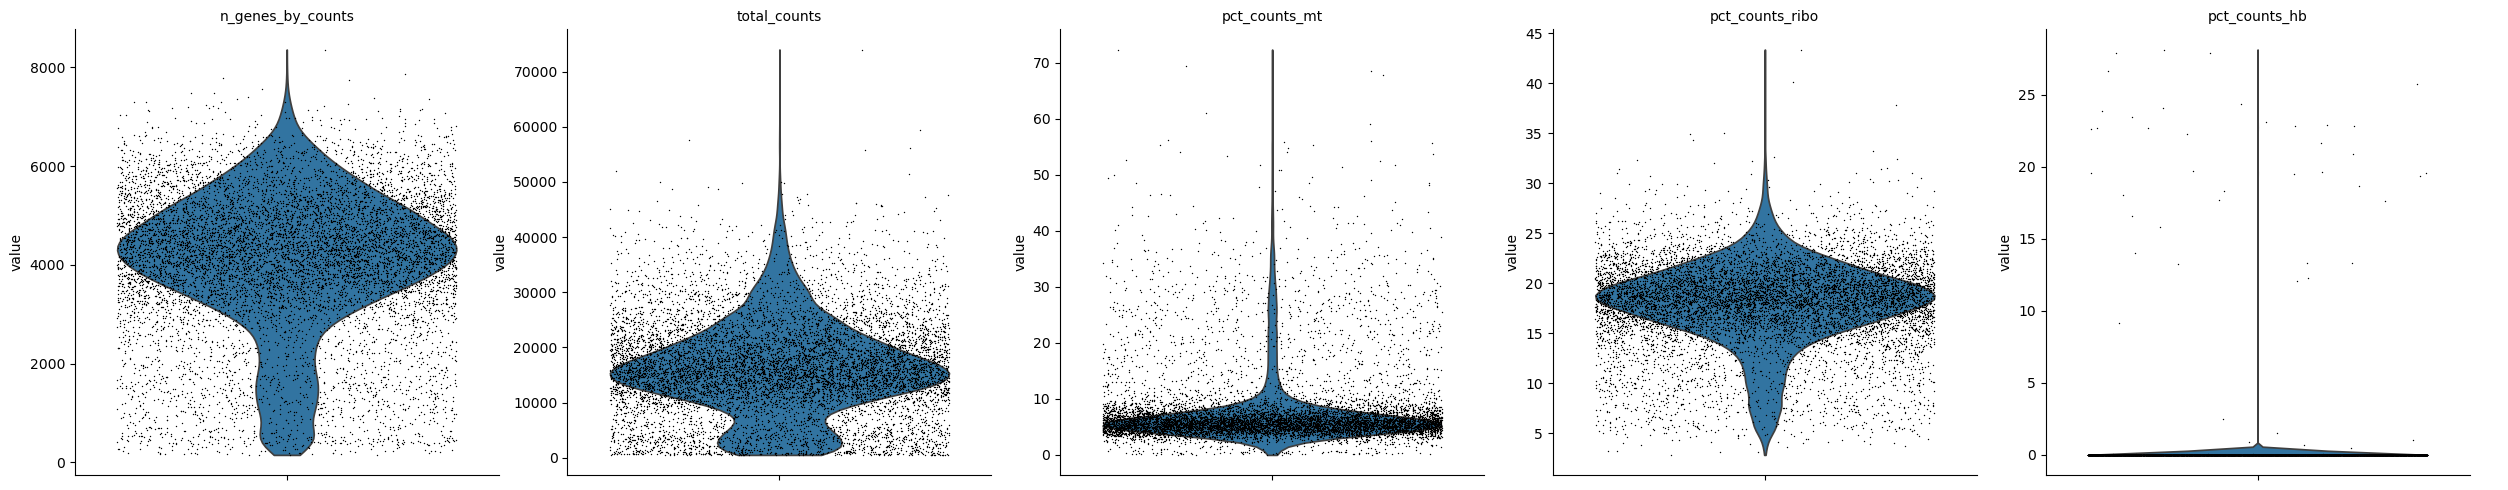

... storing 'feature_types' as categorical
... storing 'genome' as categorical


WTtdLN


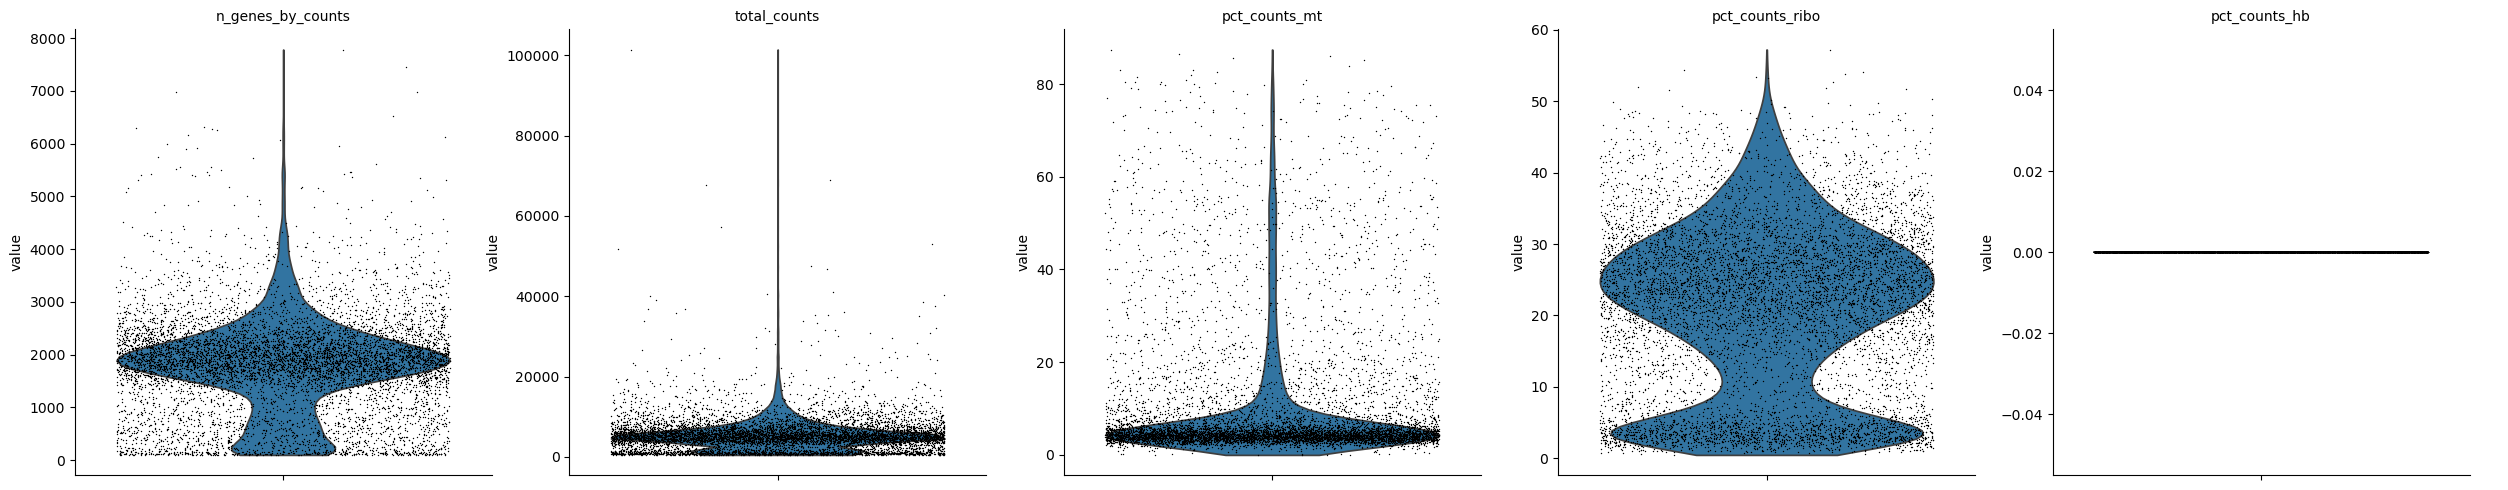

... storing 'feature_types' as categorical
... storing 'genome' as categorical


WTspleen


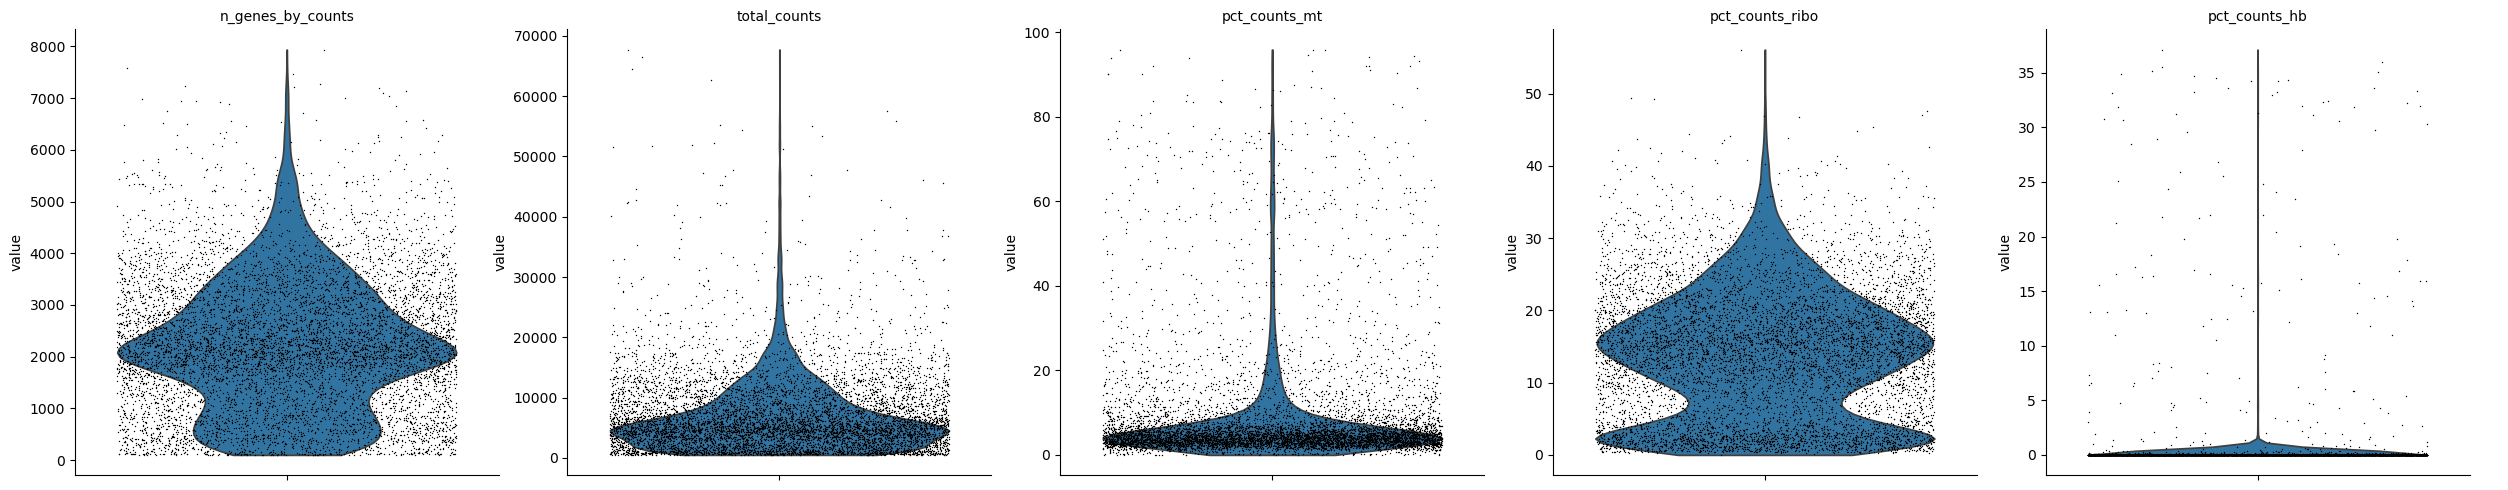

... storing 'feature_types' as categorical
... storing 'genome' as categorical


KOtumor


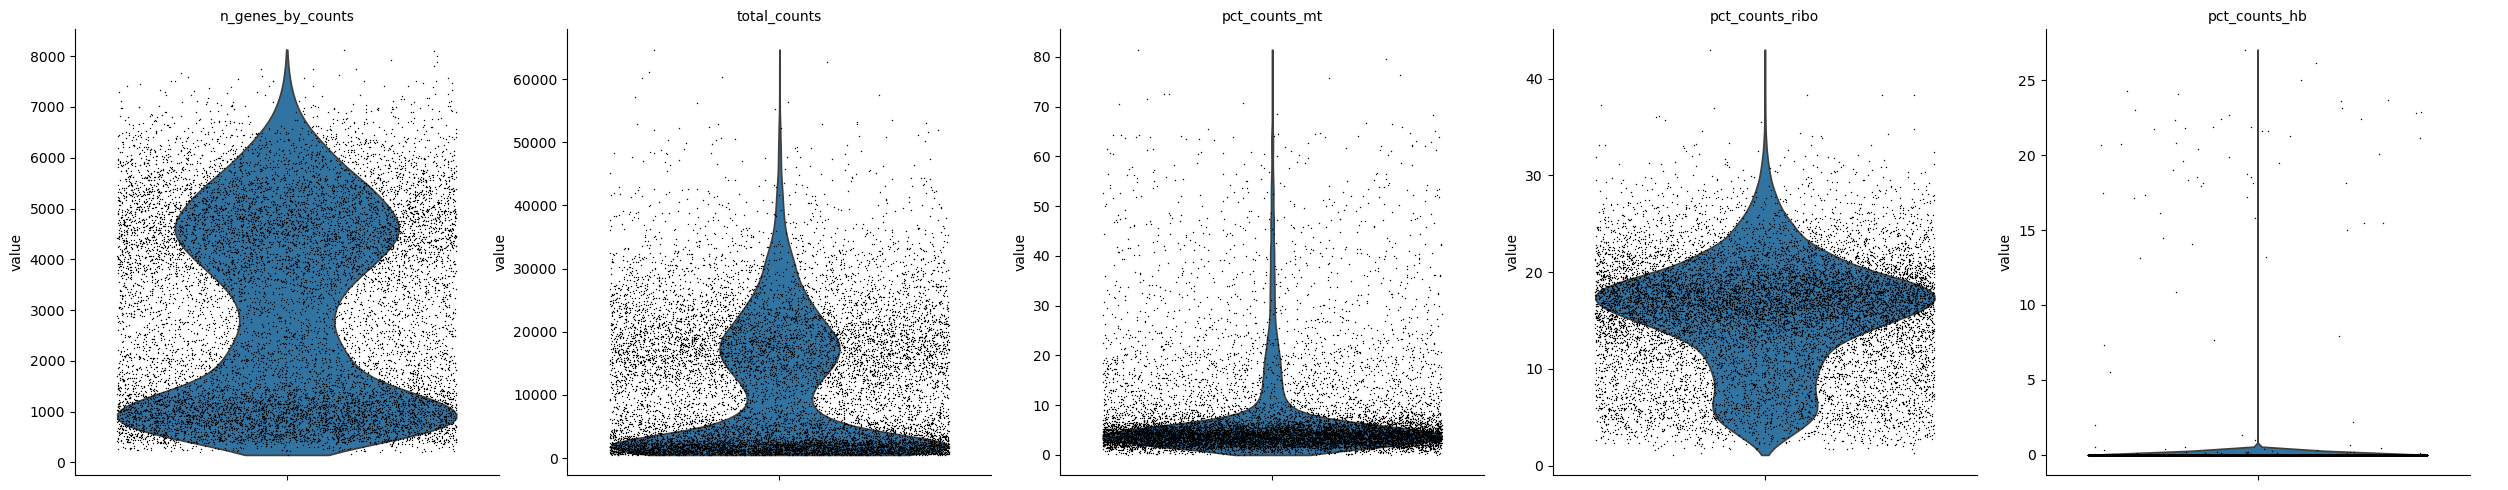

... storing 'feature_types' as categorical
... storing 'genome' as categorical


KOtdLN


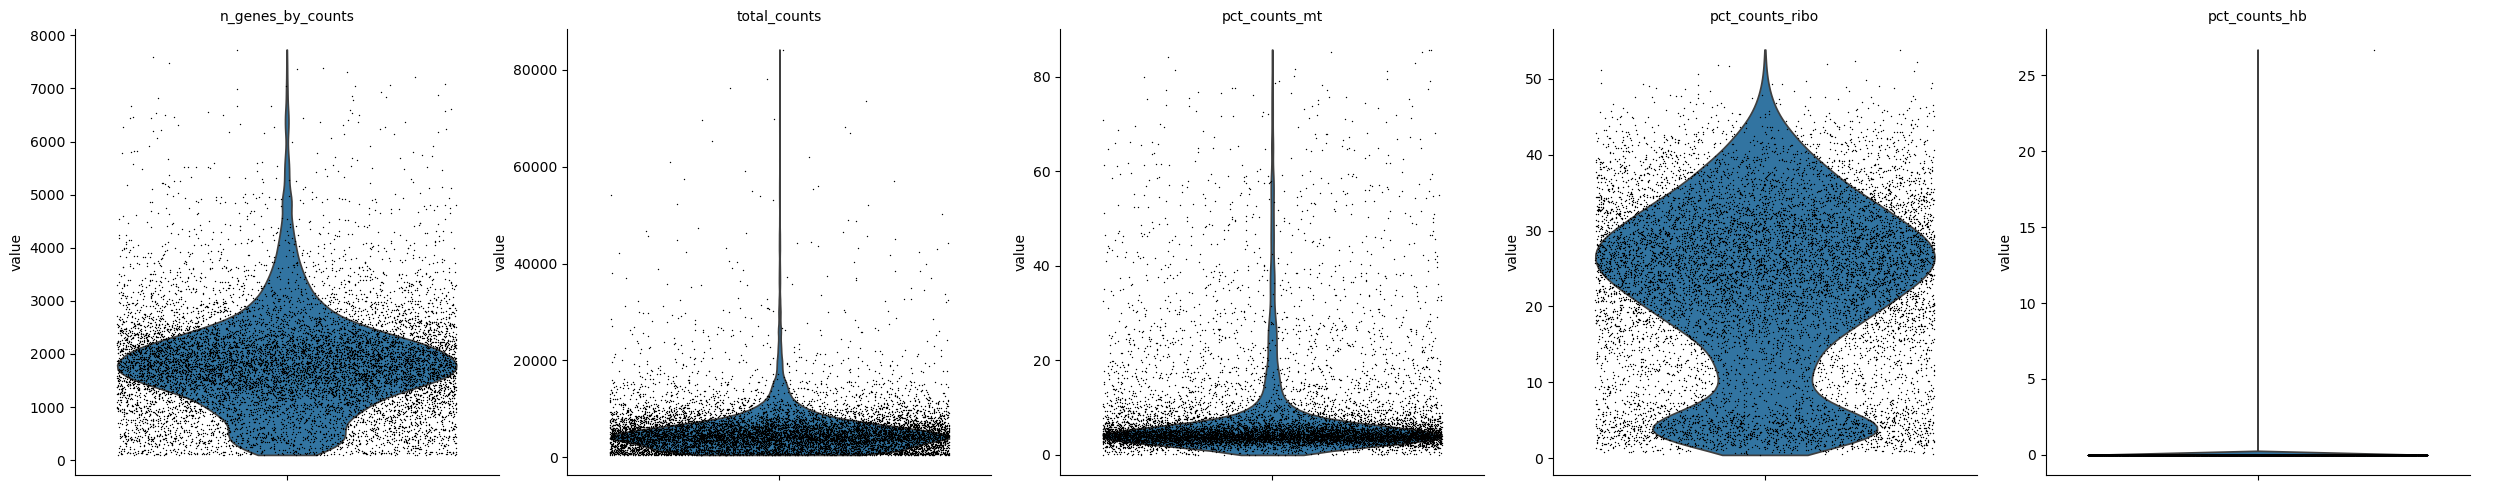

... storing 'feature_types' as categorical
... storing 'genome' as categorical


KOspleen


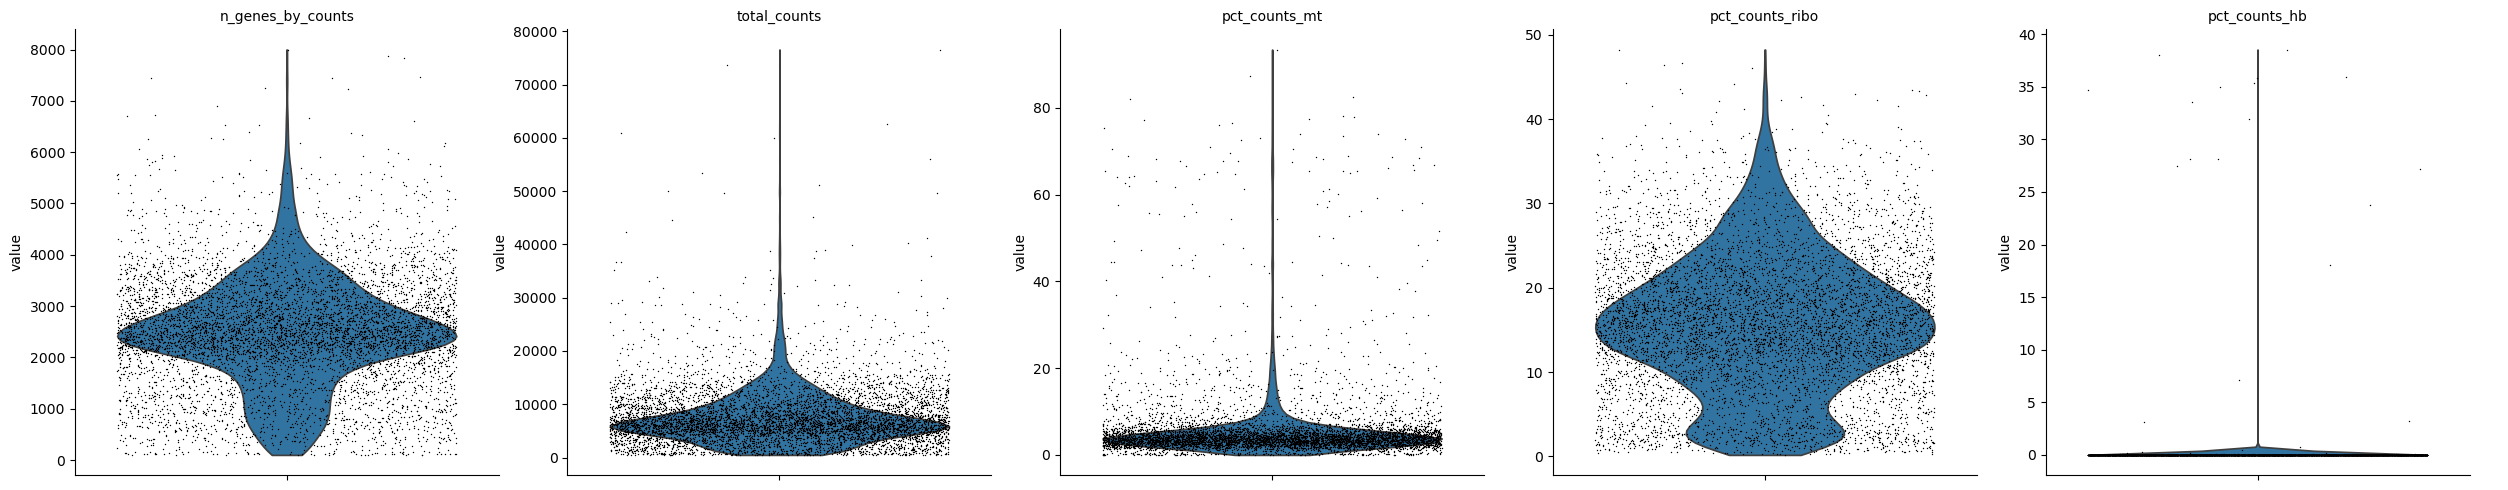

... storing 'feature_types' as categorical
... storing 'genome' as categorical


WTLNnaive


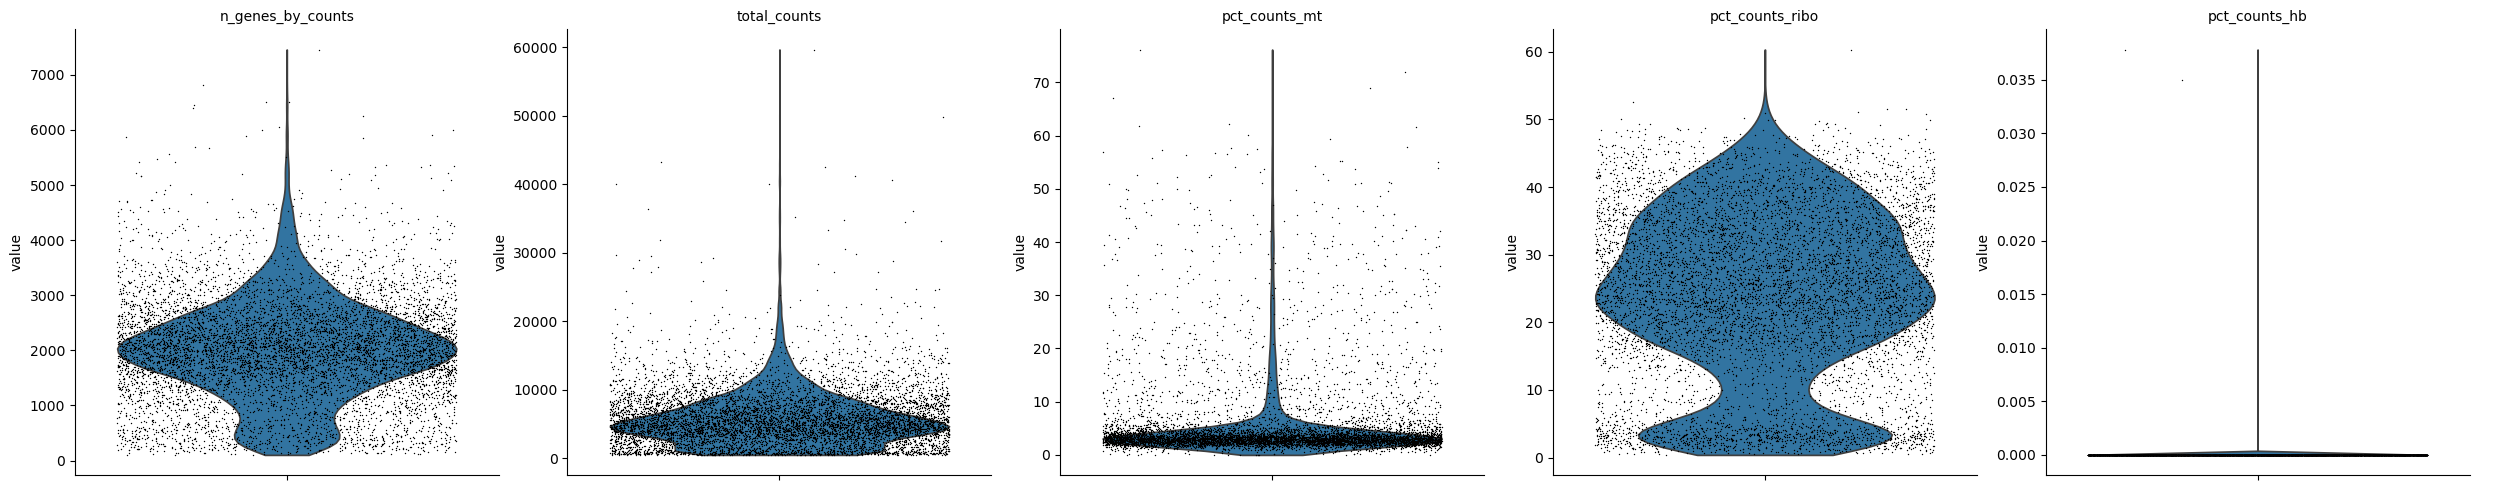

... storing 'feature_types' as categorical
... storing 'genome' as categorical


WTspleennaive


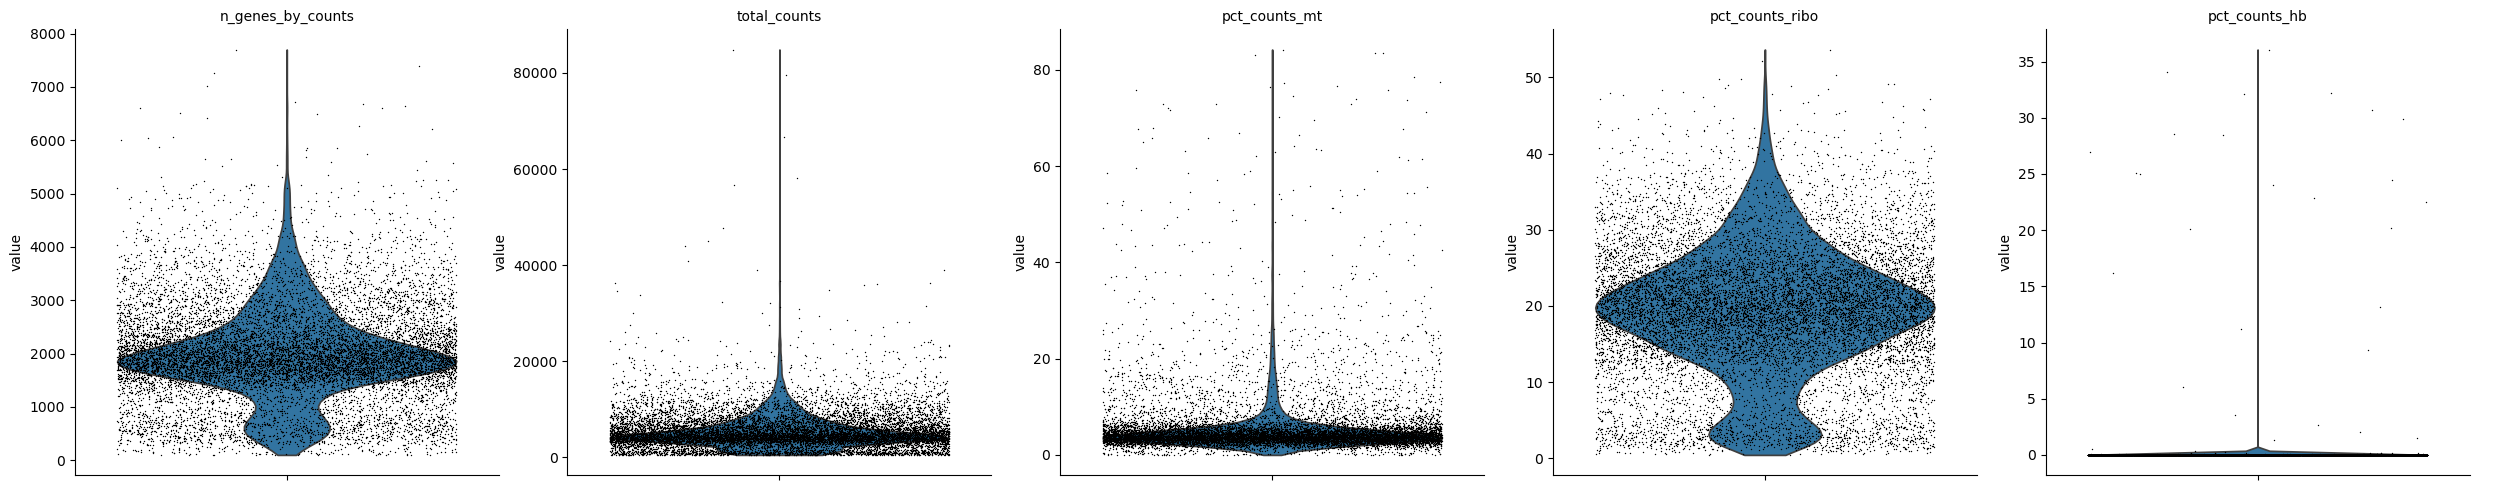

... storing 'feature_types' as categorical
... storing 'genome' as categorical


KOspleennaive


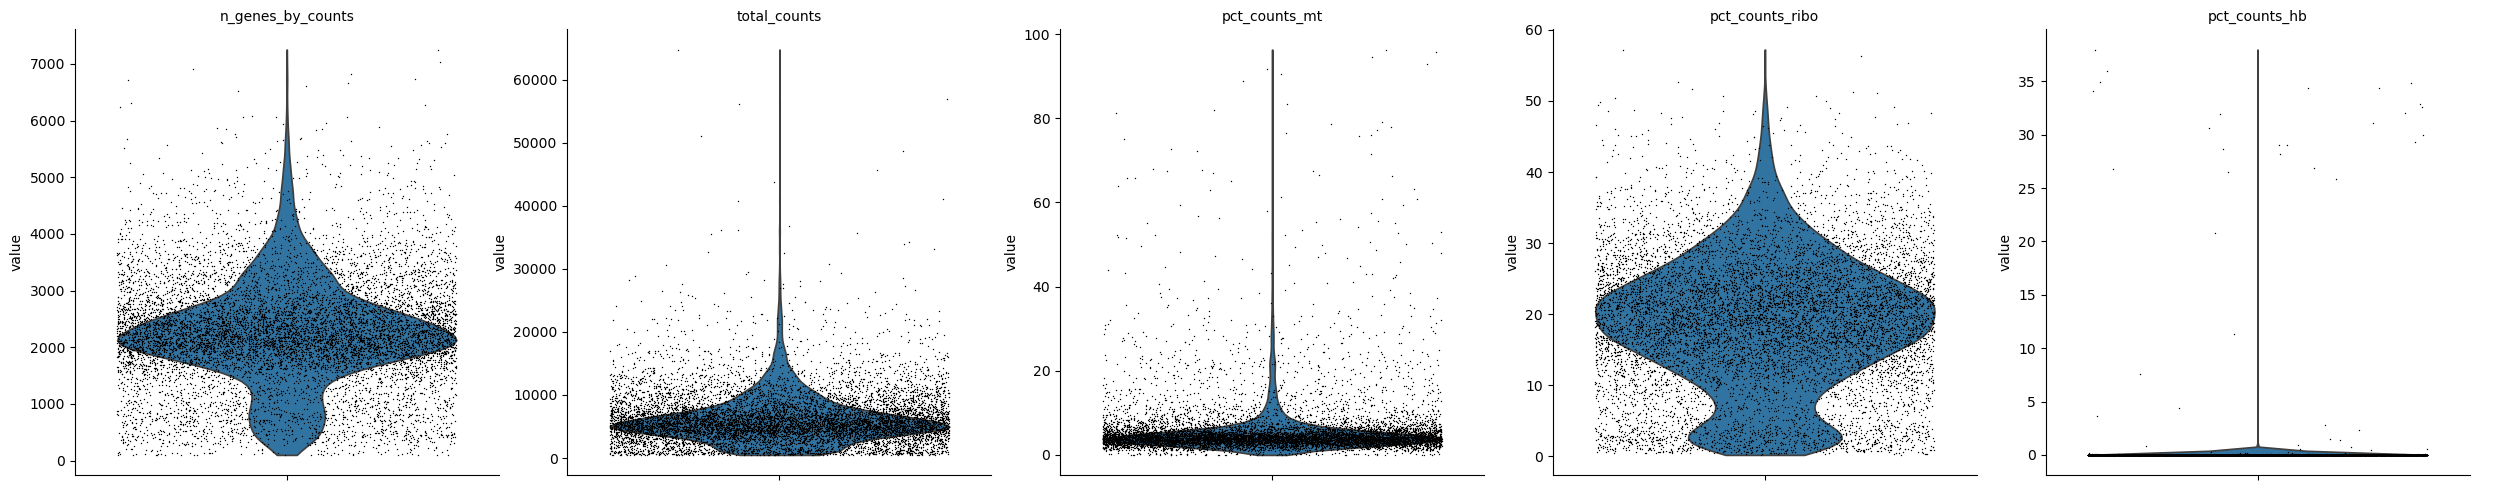

... storing 'feature_types' as categorical
... storing 'genome' as categorical


KOLNnaive


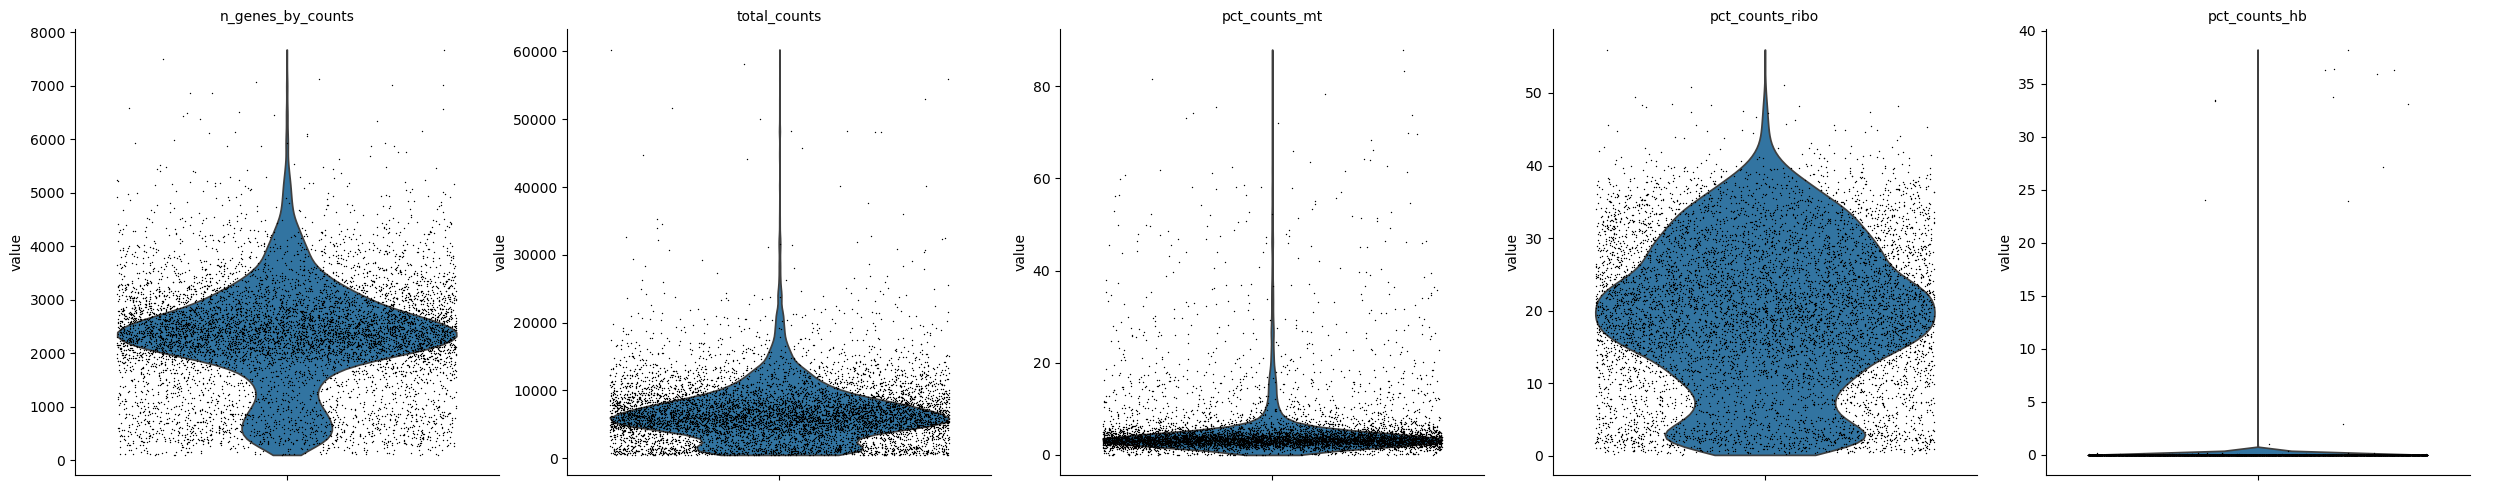

In [7]:
for sample_id, filename in samples.items():

    print(sample_id)
    sc.pl.violin(
        adatas[sample_id],
        ["n_genes_by_counts","total_counts","pct_counts_mt", "pct_counts_ribo", "pct_counts_hb"],
        jitter=0.4,
        multi_panel=True
    )



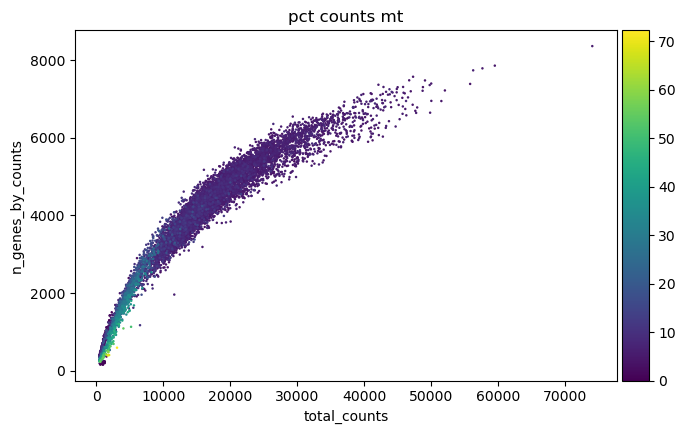

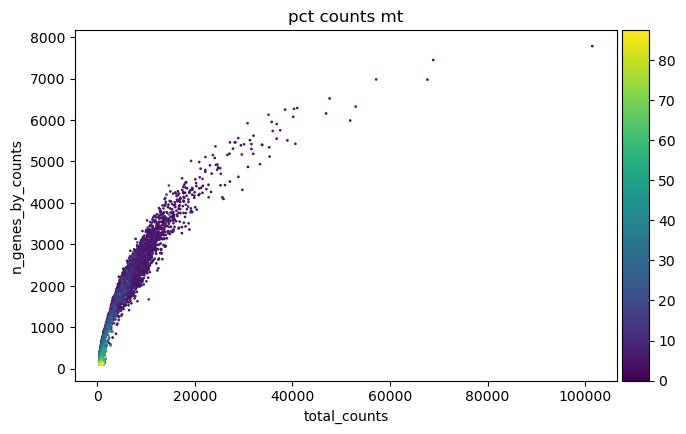

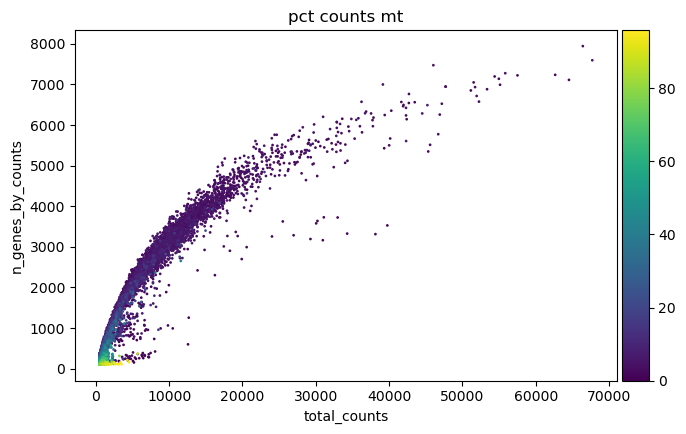

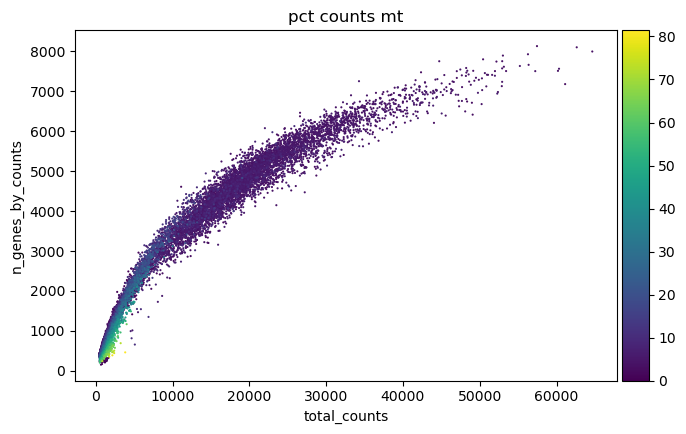

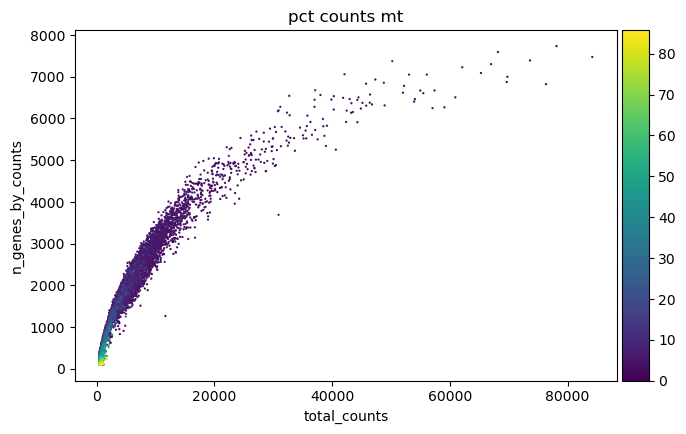

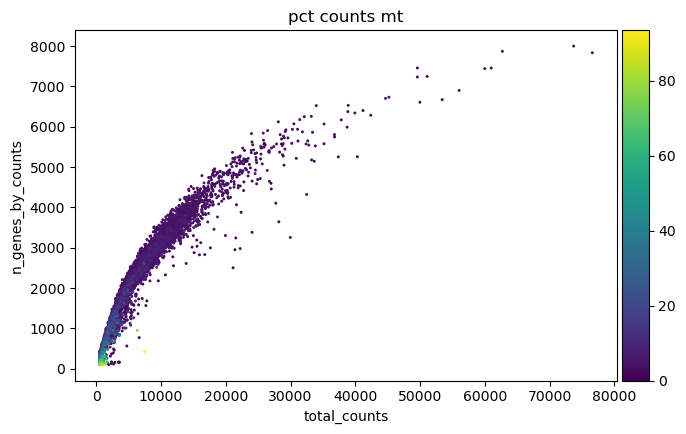

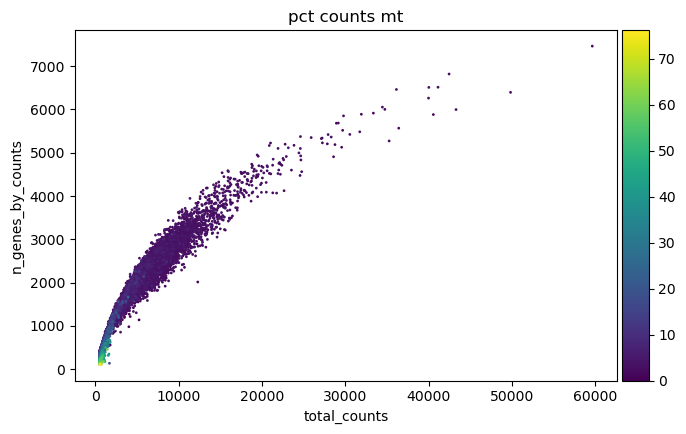

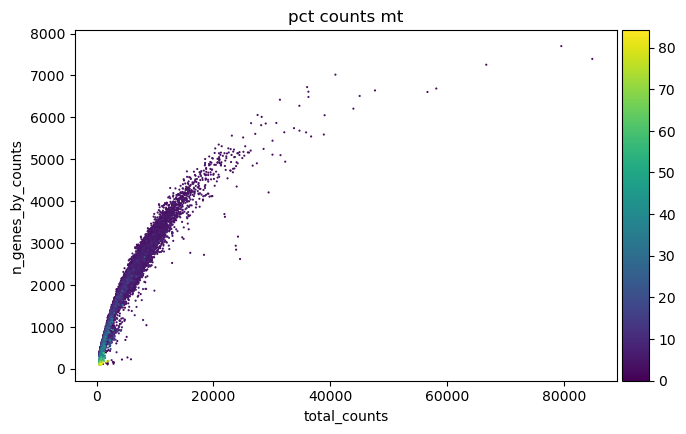

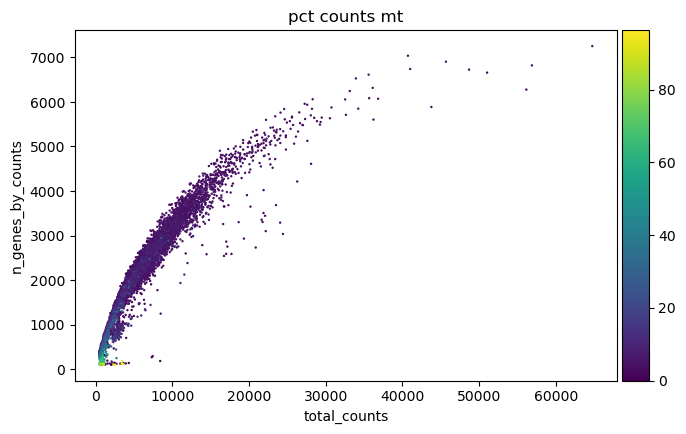

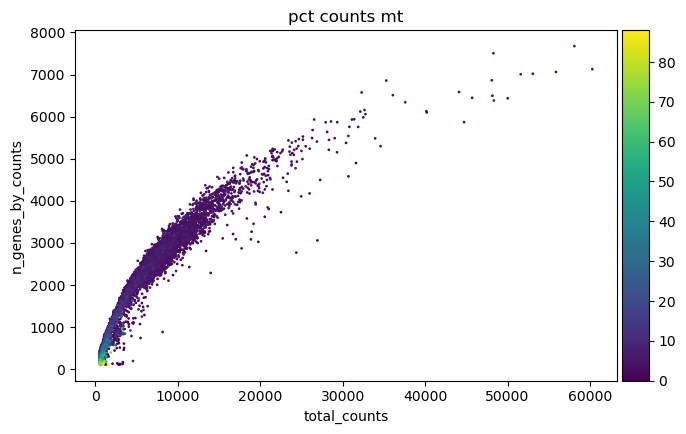

In [8]:
for sample_id, filename in samples.items():
    sc.pl.scatter(adatas[sample_id], "total_counts", "n_genes_by_counts", color="pct_counts_mt")

In [9]:
# Filter data by total counts, mt and ribo counts
for sample_id, filename in samples.items():
    
    upper_cutoff =  np.quantile(adatas[sample_id].obs.n_genes_by_counts.values, .98)
    lower_cutoff =  np.quantile(adatas[sample_id].obs.n_genes_by_counts.values, .01)
    print(f'{lower_cutoff} to {upper_cutoff}')

    adatas[sample_id] = adatas[sample_id][(adatas[sample_id].obs.n_genes_by_counts < upper_cutoff) & (adatas[sample_id].obs.n_genes_by_counts > lower_cutoff)]
    adatas[sample_id] = adatas[sample_id][adatas[sample_id].obs.pct_counts_mt < 20]
    adatas[sample_id] = adatas[sample_id][adatas[sample_id].obs.pct_counts_ribo < 50]
    adatas[sample_id] = adatas[sample_id][adatas[sample_id].obs.pct_counts_hb < 2]


383.04 to 6446.0
111.0 to 3848.38
115.0 to 5180.959999999999
367.04 to 6508.52
137.0 to 4451.699999999999
157.2 to 4891.000000000003
202.56 to 4094.5200000000004
247.32 to 4155.68
269.0 to 4495.479999999996
232.56 to 4481.52


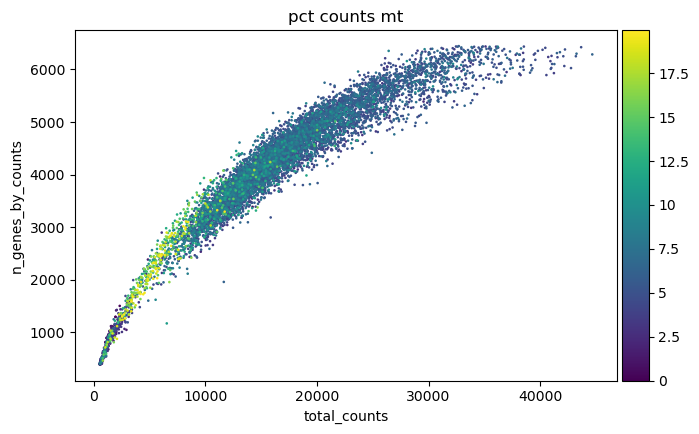

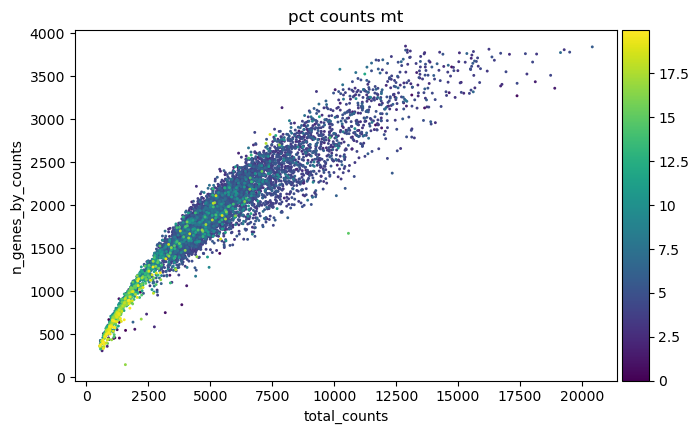

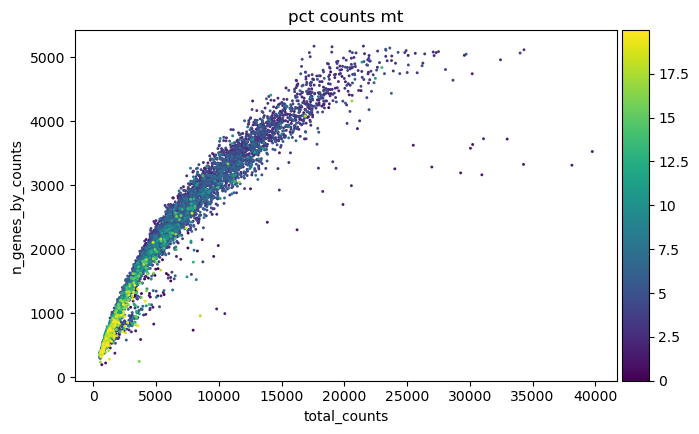

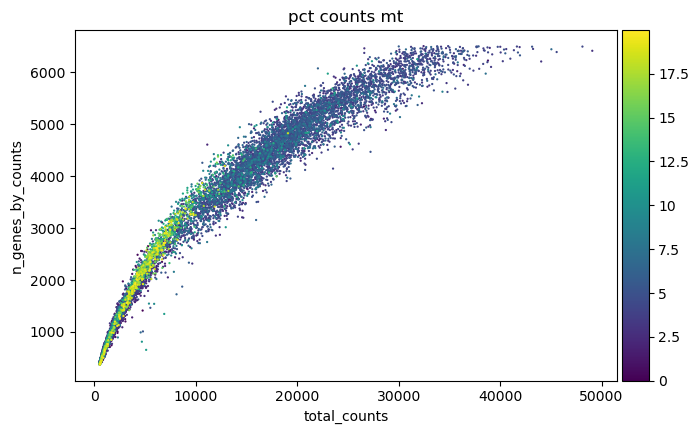

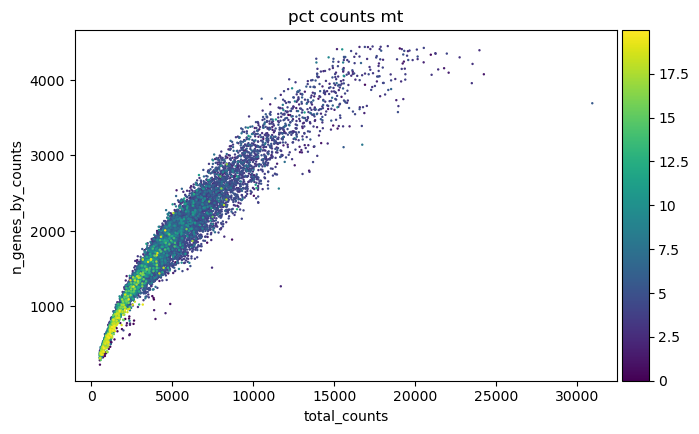

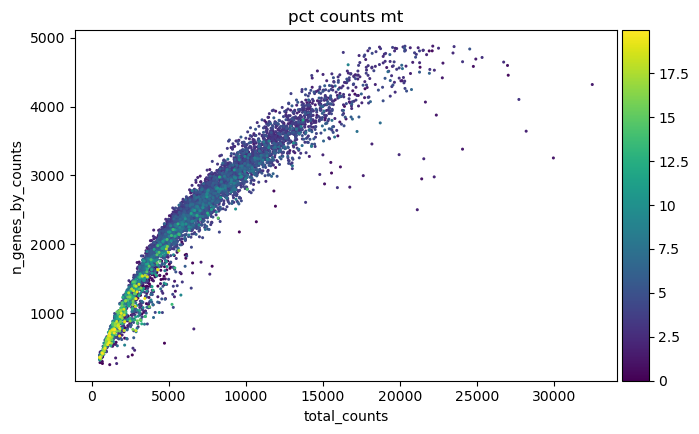

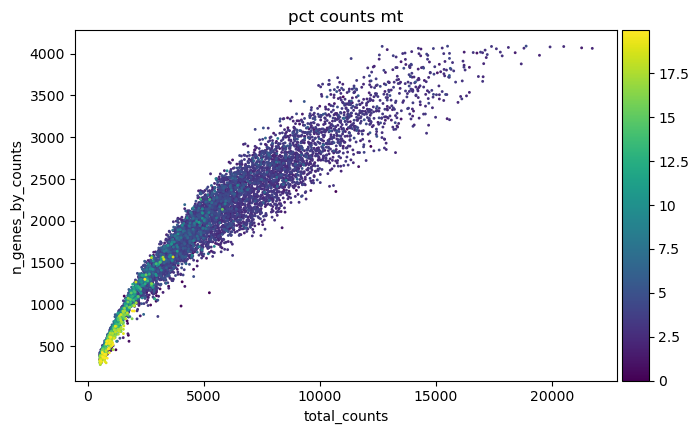

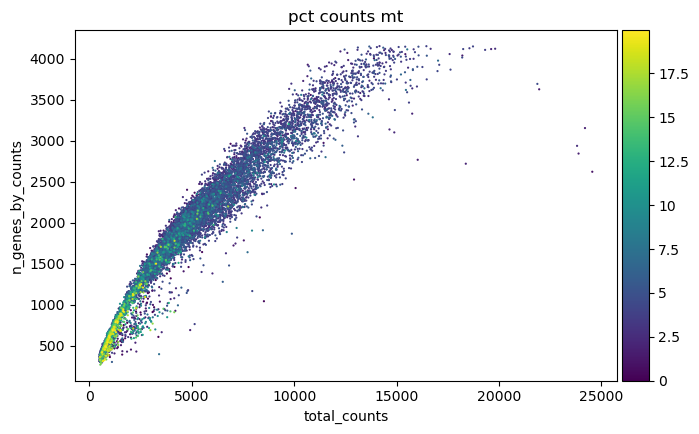

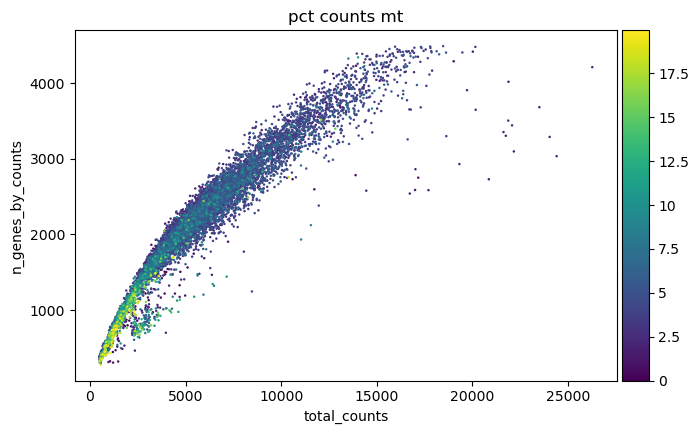

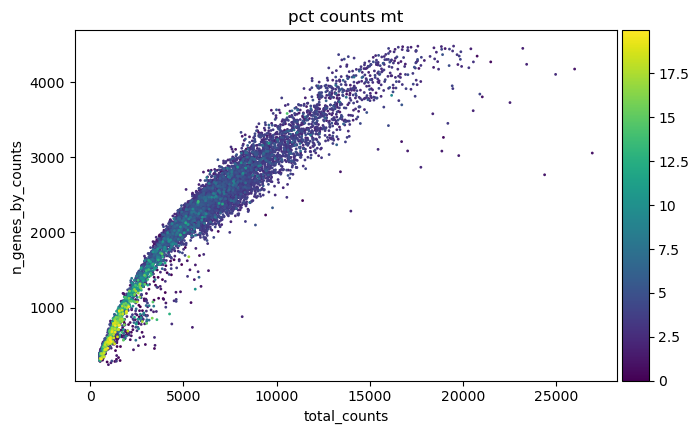

In [10]:
for sample_id, filename in samples.items():
    sc.pl.scatter(adatas[sample_id], "total_counts", "n_genes_by_counts", color="pct_counts_mt")

### Remove doublets

In [11]:
#From 10x Genomics FAQ
cells_recovered = np.array([500,1000,2000,3000,4000,5000,6000,7000, 8000, 9000, 10000])
expected_doublet_percentage = np.array([0.4, 0.8, 1.6, 2.3, 3.1, 3.9, 4.6, 5.4, 6.2, 6.9, 7.6])

In [12]:
# Approximative linear fit
b = 0.4/19
a= (0.4-b)/500
def stF(x, a= 0.000758, b= 0.0210526):
    return 0.01*(a*x+b)

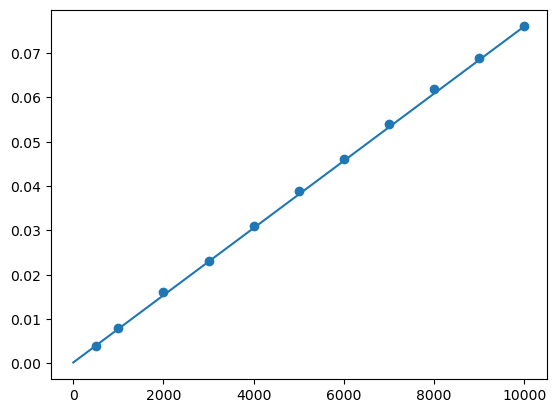

In [13]:
plt.scatter(cells_recovered,expected_doublet_percentage/100.)
plt.plot(np.arange(10000),stF(np.arange(10000)))
plt.show()

In [14]:
import scrublet as scr

In [15]:
for sample_id, filename in samples.items():

    expected_rate = stF(adatas[sample_id].shape[0])
    scrub = scr.Scrublet(adatas[sample_id].X, expected_doublet_rate = expected_rate)
    adatas[sample_id].obs['doublet_scores'], adatas[sample_id].obs['predicted_doublets'] = scrub.scrub_doublets(min_counts=2, min_cells=3, 
                                                          min_gene_variability_pctl=85, n_prin_comps=30)


Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.59
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 0.3%
Overall doublet rate:
	Expected   = 6.5%
	Estimated  = 13.6%
Elapsed time: 7.4 seconds
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.30
Detected doublet rate = 1.1%
Estimated detectable doublet fraction = 31.2%
Overall doublet rate:
	Expected   = 5.2%
	Estimated  = 3.7%
Elapsed time: 6.7 seconds
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.25
Detected doublet rate = 1.9%
Estimated detectable doublet fraction = 29.6%
Overall doublet rate:
	Expected   = 5.2%
	Estimated  = 6.5%
Elapsed time: 5.7 seconds
Preprocessing...
Simulating doublets.

In [16]:
# Remove doublets 
for sample_id, filename in samples.items():
    print(adatas[sample_id].obs['predicted_doublets'].value_counts())
    adatas[sample_id] = adatas[sample_id][adatas[sample_id].obs['predicted_doublets'] == False]

predicted_doublets
False    8489
True        3
Name: count, dtype: int64
predicted_doublets
False    6814
True       79
Name: count, dtype: int64
predicted_doublets
False    6729
True      132
Name: count, dtype: int64
predicted_doublets
False    11154
True       240
Name: count, dtype: int64
predicted_doublets
False    9688
True      339
Name: count, dtype: int64
predicted_doublets
False    6210
True       97
Name: count, dtype: int64
predicted_doublets
False    6970
True      129
Name: count, dtype: int64
predicted_doublets
False    11607
True       353
Name: count, dtype: int64
predicted_doublets
False    9289
True      182
Name: count, dtype: int64
predicted_doublets
False    7240
True      169
Name: count, dtype: int64


## Concatenate samples by tissue type: tumor, LN, and spleen

In [17]:
adata={}

adata['tumor'] = ad.concat((adatas["WTtumor"], adatas["KOtumor"]), label="sample")
adata['tumor'].obs_names_make_unique()
adata['tumor'].obs['WT/KO'] = adata['tumor'].obs['sample'].cat.rename_categories({'0': 'wt', '1': 'ko'})
adata['tumor'].obs['pathogenicity'] = 'pathogenic'
adata['tumor'].obs['sample'] = adata['tumor'].obs['sample'].cat.rename_categories({'0': 'wt_pathogenic', '1': 'ko_pathogenic'})

adata['LNnaive'] = ad.concat((adatas["WTLNnaive"],adatas["KOLNnaive"]), label="sample")
adata['LNnaive'].obs_names_make_unique()
adata['LNnaive'].obs['WT/KO'] = adata['LNnaive'].obs['sample'].cat.rename_categories({'0': 'wt', '1': 'ko'})
adata['LNnaive'].obs['pathogenicity'] = 'naive'

adata['tdLN'] = ad.concat((adatas["WTtdLN"],adatas["KOtdLN"]), label="sample")
adata['tdLN'].obs_names_make_unique()
adata['tdLN'].obs['WT/KO'] = adata['tdLN'].obs['sample'].cat.rename_categories({'0': 'wt', '1': 'ko'})
adata['tdLN'].obs['pathogenicity'] = 'pathogenic'

adata['spleennaive'] = ad.concat((adatas["WTspleennaive"],adatas["KOspleennaive"]), label="sample")
adata['spleennaive'].obs_names_make_unique()
adata['spleennaive'].obs['WT/KO'] = adata['spleennaive'].obs['sample'].cat.rename_categories({'0': 'wt', '1': 'ko'})
adata['spleennaive'].obs['pathogenicity'] = 'naive'

adata['spleen_p'] = ad.concat((adatas["WTspleen"],adatas["KOspleen"]), label="sample")
adata['spleen_p'].obs_names_make_unique()
adata['spleen_p'].obs['WT/KO'] = adata['spleen_p'].obs['sample'].cat.rename_categories({'0': 'wt', '1': 'ko'})
adata['spleen_p'].obs['pathogenicity'] = 'pathogenic'

adata['LN'] = ad.concat((adata['LNnaive'],adata["tdLN"]), label="pathogenicity")
adata['LN'].obs['pathogenicity'] = adata['LN'].obs['pathogenicity'].cat.rename_categories({'0': 'naive', '1': 'pathogenic'})
adata['LN'].obs['sample'] = (adata['LN'].obs[['WT/KO']].values+'_'+adata['LN'].obs[['pathogenicity']].values).flatten()

adata['spleen'] = ad.concat((adata['spleennaive'],adata["spleen_p"]), label="pathogenicity")
adata['spleen'].obs['pathogenicity'] = adata['spleen'].obs['pathogenicity'].cat.rename_categories({'0': 'naive', '1': 'pathogenic'})
adata['spleen'].obs['sample'] = (adata['spleen'].obs[['WT/KO']].values+'_'+adata['spleen'].obs[['pathogenicity']].values).flatten()

tissues = ['tumor','LN','spleen']


In [18]:
np.unique(adata['tumor'].obs['sample'].values)

array(['ko_pathogenic', 'wt_pathogenic'], dtype=object)

In [19]:
# Filter out genes that are expressed in less than 3 cells. This leaves us with approx 20k genes in each adata object
for tissue in tissues:

    sc.pp.filter_genes(adata[tissue], min_cells=3)
    

In [20]:
### Save adata objects
adata['tumor'].write("maranou_032024_tumor.h5ad")
adata['spleen'].write("maranou_032024_spleen.h5ad")
adata['LN'].write("maranou_032024_LN.h5ad")

... storing 'pathogenicity' as categorical
... storing 'sample' as categorical
... storing 'sample' as categorical


### Restart kernel here and reload data because Scrublet impairs plotting

In [1]:
import numpy as np
import seaborn as sns

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.legend import Legend
import matplotlib.colors as colors
from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d


import pandas as pd
import scipy
import scanpy as sc
import anndata as ad

## Could not get scvi working 
# import scvi

from sklearn import datasets
from sklearn.decomposition import PCA

from numba import jit

import celltypist
from celltypist import models

from matplotlib.cm import ScalarMappable

In [2]:
adata = {}

adata['tumor']=sc.read("maranou_032024_tumor.h5ad")
adata['LN']=sc.read("maranou_032024_LN.h5ad")
adata['spleen']=sc.read("maranou_032024_spleen.h5ad")

tissues = ['tumor','LN','spleen']

### Normalize cell counts to 10k and log1p transform

In [3]:
for tissue in tissues:

    # Save raw counts before normalization 
    adata[tissue].layers["counts"] = adata[tissue].X.copy()
    
    sc.pp.normalize_total(adata[tissue], target_sum=1e4)
    sc.pp.log1p(adata[tissue])

In [5]:
# ### Save normalized and scaled objects 

adata['tumor'].write("maranou_032024_tumor_scaled.h5ad")
adata['spleen'].write("maranou_032024_spleen_scaled.h5ad")
adata['LN'].write("maranou_032024_LN_scaled.h5ad")

### Find highly variable genes

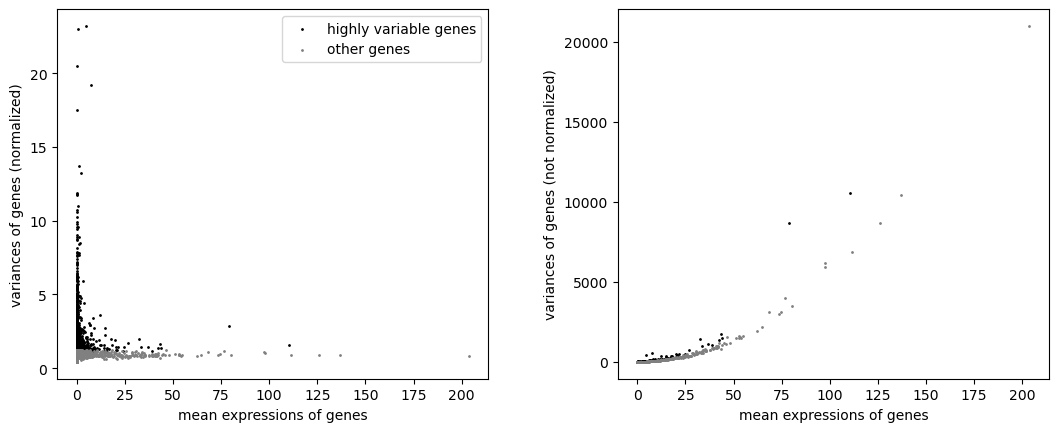

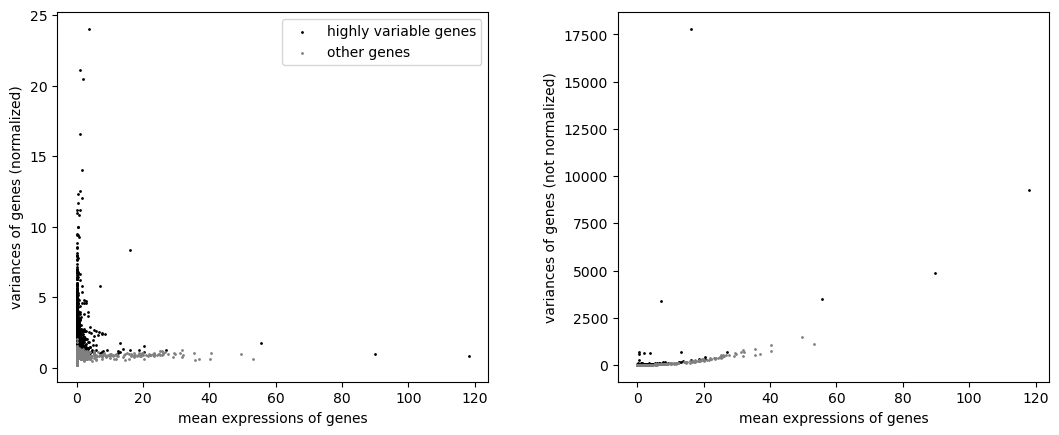

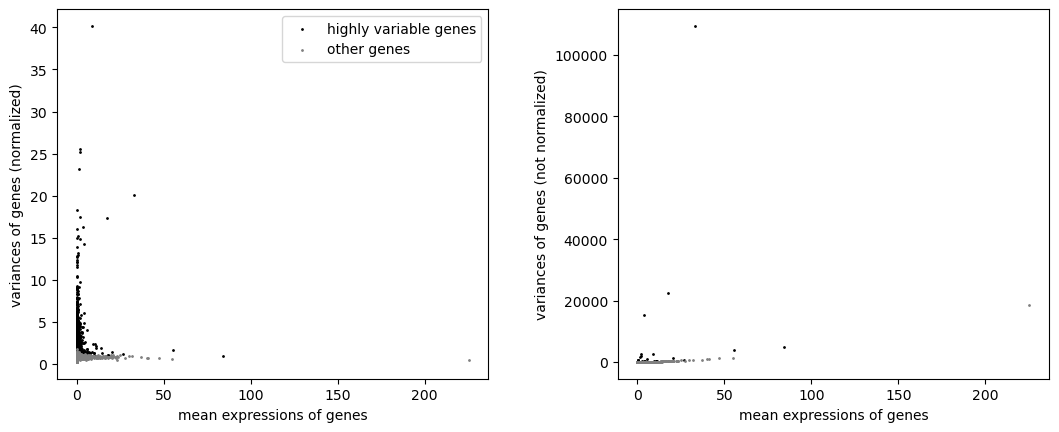

In [6]:
for tissue in tissues:

    ntop = int(0.15*adata[tissue].shape[0])
    
    # label True/False for high variability using default parameters
    sc.pp.highly_variable_genes(adata[tissue], layer = 'counts', n_top_genes = ntop, flavor = 'seurat_v3', batch_key = 'sample')

    sc.pl.highly_variable_genes(adata[tissue])
    
    # Basic Seurat implementation uses log-transformed counts
    # sc.pp.highly_variable_genes(adata[sample], min_mean=0.0125, max_mean=3, min_disp=0.5, batch_key = 'sample')
    
    # Save raw data
    adata[tissue].raw = adata[tissue]
    

In [7]:
for tissue in tissues:

    print(tissue)
    print("HVG intersection: %d"%sum(adata[tissue].var.highly_variable_nbatches == 4))
    print("HVG in more than 2: %d"%sum(adata[tissue].var.highly_variable_nbatches > 2))
    print("HVG in more than 1: %d"%sum(adata[tissue].var.highly_variable_nbatches > 1))
    print("HVG union: %d"%sum(adata[tissue].var.highly_variable_nbatches >0))
    print("HVG: %d"%sum(adata[tissue].var.highly_variable))
    

tumor
HVG intersection: 0
HVG in more than 2: 0
HVG in more than 1: 1928
HVG union: 3964
HVG: 2946
LN
HVG intersection: 2158
HVG in more than 2: 3305
HVG in more than 1: 4920
HVG union: 8041
HVG: 4606
spleen
HVG intersection: 2903
HVG in more than 2: 4008
HVG in more than 1: 5428
HVG union: 7961
HVG: 5075


In [10]:
for tissue in tissues:

    # Keep genes that are hvg in at least one sample
    adata[tissue] = adata[tissue][:,adata[tissue].var.highly_variable_nbatches >0]


### Integration of WT/KO samples using Scanorama

#### MNN and Scanorama are state-of-the-art tools of scRNA-seq data integration. Both are known for solid integration without altering biological features. Li et al. in https://cellregeneration.springeropen.com/articles/10.1186/s13619-020-00041-9 found Scanorama more insensitive to input order and less vulnerable to overcorrection. I also tried integrating four samples from the same tissue type together but that resulted in Leiden clusters that obviously did not represent cellular phenotype. The integration of naive and pathogenic samples therefore needs to be done as a further step.  

In [10]:
import scanorama

In [11]:
adata['tumor'].layers['counts']

<19643x21814 sparse matrix of type '<class 'numpy.float32'>'
	with 70454456 stored elements in Compressed Sparse Row format>

In [18]:
adata_sc = {}

for tissue in ['tumor']:
    
    var_select = adata[tissue].var.highly_variable_nbatches > 1
    var_genes = var_select.index[var_select]
    
    batches = ['wt_pathogenic','ko_pathogenic']
    
    adata_raw = sc.AnnData(X=adata[tissue].raw.X, var=adata[tissue].raw.var, obs = adata[tissue].obs)
    
    adata2 = {}
    for batch in batches:
        adata2[batch] = adata_raw[adata_raw.obs['sample'] == batch]
    
    
    # split per batch into new objects.
    adata3= dict()
    for ds in adata2.keys():
        print(ds)
        adata3[ds] = adata2[ds][:,var_genes]
    
    #convert to list of AnnData objects
    adatas2 = list(adata3.values())
    
    # run scanorama.integrate
    scanorama.integrate_scanpy(adatas2, dimred = 50)
    
    scanorama_int = [ad.obsm['X_scanorama'] for ad in adatas2]
    
    # Concatenate into one matrix
    all_s = np.concatenate(scanorama_int)
    print(all_s.shape)
    
    # add to the AnnData object, create a new object first
    adata_sc[tissue] = sc.AnnData(X=adata[tissue].raw.X, var=adata[tissue].raw.var, obs = adata[tissue].obs)
    print(tissue, adata_sc[tissue])

    #This was in a tutorial but it replaces counts by scaled counts. Therefore, original counts are copied as true_counts
    # adata_sc[tissue].layers["counts"] = adata_sc[tissue].X.copy()
    adata_sc[tissue].layers["counts"] = adata[tissue].layers["counts"]

    print(tissue, adata_sc[tissue].layers["counts"].todense().shape)
    
    # #normalize and log-transform
    sc.pp.normalize_per_cell(adata_sc[tissue], counts_per_cell_after=1e4)
    sc.pp.log1p(adata_sc[tissue])

    ntop = int(0.15*adata_sc[tissue].shape[0])
    # print('ntop:', ntop)
    
    # label True/False for high variability using default parameters
    sc.pp.highly_variable_genes(adata_sc[tissue], layer = 'counts', n_top_genes = ntop, flavor = 'seurat_v3', batch_key = 'sample')
    # sc.pp.highly_variable_genes(adata_sc[tissue], min_mean=0.0125, max_mean=3, min_disp=0.5,  batch_key='WT/KO')

    #Save raw data from the original adata
    adata_sc[tissue].raw = adata_sc[tissue]
    
    # Filter again for hvg's
    # adata_sc[tissue] = adata_sc[tissue][:,adata_sc[tissue].var.highly_variable_nbatches > 0]
    
    # sc.pl.highly_variable_genes(adata_sc[tissue])
    
    # regress_out is not needed with Scanorama
    # sc.pp.regress_out(adata_sc[tissue], ['total_counts', 'pct_counts_mt', 'pct_counts_ribo'])
    
    adata_sc[tissue].obsm["Scanorama"] = all_s

wt_pathogenic
ko_pathogenic
Found 1928 genes among all datasets
[[0.         0.89610084]
 [0.         0.        ]]
Processing datasets (0, 1)
(19643, 50)
tumor AnnData object with n_obs × n_vars = 19643 × 21814
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'doublet_scores', 'predicted_doublets', 'sample', 'WT/KO', 'pathogenicity'
    var: 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
tumor (19643, 21814)


wt_pathogenic
ko_pathogenic
Found 1928 genes among all datasets
[[0.         0.89610084]
 [0.         0.        ]]
Processing datasets (0, 1)
(19643, 50)
tumor AnnData object with n_obs × n_vars = 19643 × 21814
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'doublet_scores', 'predicted_doublets', 'sample', 'WT/KO', 'pathogenicity'
    var: 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
tumor (19643, 21814)


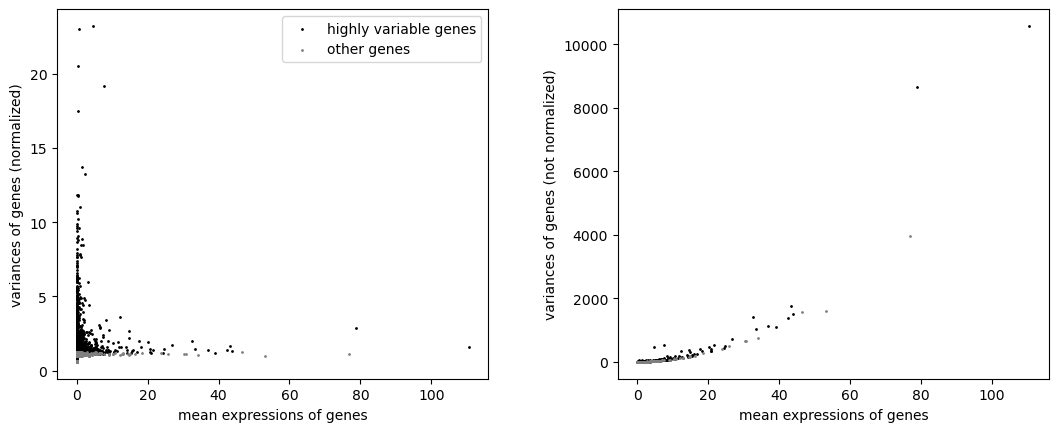

wt_naive
ko_naive
wt_pathogenic
ko_pathogenic
Found 3305 genes among all datasets
[[0.         0.71878453 0.35093257 0.53816356]
 [0.         0.         0.20359116 0.81698895]
 [0.         0.         0.         0.63384209]
 [0.         0.         0.         0.        ]]
Processing datasets (1, 3)
Processing datasets (0, 1)
Processing datasets (2, 3)
Processing datasets (0, 3)
Processing datasets (0, 2)
Processing datasets (1, 2)
(30712, 50)
LN AnnData object with n_obs × n_vars = 30712 × 21803
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'doublet_scores', 'predicted_doublets', 'sample', 'WT/KO', 'pathogenicity'
    var: 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
LN (30712, 21803)
wt_naive
ko_naive
wt_pathogenic
ko_pathogenic
Found 4008 genes among all datasets
[[0.         0.78253849 0.8

In [12]:

for tissue in ['LN','spleen']:

    # For naive/pathogenic integration we restrict more the set of hvg's 
    var_select = adata[tissue].var.highly_variable_nbatches > 2
    var_genes = var_select.index[var_select]
    
    batches = ['wt_naive','ko_naive','wt_pathogenic','ko_pathogenic']
    
    adata_raw = sc.AnnData(X=adata[tissue].raw.X, var=adata[tissue].raw.var, obs = adata[tissue].obs)
    
    adata2 = {}
    for batch in batches:
        adata2[batch] = adata_raw[adata_raw.obs['sample'] == batch]
    
    
    # split per batch into new objects.
    adata3= dict()
    for ds in adata2.keys():
        print(ds)
        adata3[ds] = adata2[ds][:,var_genes]
    
    #convert to list of AnnData objects
    adatas2 = list(adata3.values())
    
    # run scanorama.integrate
    scanorama.integrate_scanpy(adatas2, dimred = 50)
    
    scanorama_int = [ad.obsm['X_scanorama'] for ad in adatas2]
    
    # Concatenate into one matrix
    all_s = np.concatenate(scanorama_int)
    print(all_s.shape)
    
    # add to the AnnData object, create a new object first
    adata_sc[tissue] = sc.AnnData(X=adata[tissue].raw.X, var=adata[tissue].raw.var, obs = adata[tissue].obs)
    print(tissue, adata_sc[tissue])
    
    # adata_sc[tissue].layers["counts"] = adata_sc[tissue].X.copy()
    adata_sc[tissue].layers["counts"] = adata[tissue].layers["counts"]

    print(tissue, adata_sc[tissue].layers["counts"].todense().shape)
    
    # #normalize and log-transform
    sc.pp.normalize_per_cell(adata_sc[tissue], counts_per_cell_after=1e4)
    sc.pp.log1p(adata_sc[tissue])

    ntop = int(0.15*adata_sc[tissue].shape[0])
    # print('ntop:', ntop)
    
    # label True/False for high variability using default parameters
    sc.pp.highly_variable_genes(adata_sc[tissue], layer = 'counts', n_top_genes = ntop, flavor = 'seurat_v3', batch_key = 'sample')
    # sc.pp.highly_variable_genes(adata_sc[tissue], min_mean=0.0125, max_mean=3, min_disp=0.5,  batch_key='WT/KO')

    #Save raw data from the original adata
    adata_sc[tissue].raw = adata_sc[tissue]
    
    # Filter again for hvg's
    # adata_sc[tissue] = adata_sc[tissue][:,adata_sc[tissue].var.highly_variable_nbatches > 0]
    
    # sc.pl.highly_variable_genes(adata_sc[tissue])
    
    # regress_out is not needed with Scanorama
    # sc.pp.regress_out(adata_sc[tissue], ['total_counts', 'pct_counts_mt', 'pct_counts_ribo'])
    
    adata_sc[tissue].obsm["Scanorama"] = all_s

In [13]:
for tissue in tissues:

    sc.pp.pca(adata_sc[tissue], n_comps=30, use_highly_variable=True, svd_solver='arpack')
    sc.pp.neighbors(adata_sc[tissue], n_pcs =30, use_rep = "Scanorama")
    sc.tl.leiden(adata_sc[tissue], resolution=0.3)
    sc.tl.umap(adata_sc[tissue])
    sc.tl.tsne(adata_sc[tissue], n_pcs = 30, use_rep = "Scanorama")
    

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


### Save integrated data

In [16]:
adata_sc['tumor'].write("maranou_032024_tumor_integrated.h5ad")
adata_sc['spleen'].write("maranou_032024_spleen_integrated.h5ad")
adata_sc['LN'].write("maranou_032024_LN_integrated.h5ad")

In [17]:
adata_sc

{'tumor': AnnData object with n_obs × n_vars = 19643 × 3964
     obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'doublet_scores', 'predicted_doublets', 'sample', 'WT/KO', 'pathogenicity', 'n_counts', 'leiden'
     var: 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
     uns: 'log1p', 'hvg', 'pca', 'neighbors', 'leiden', 'umap', 'tsne'
     obsm: 'Scanorama', 'X_pca', 'X_umap', 'X_tsne'
     varm: 'PCs'
     layers: 'counts'
     obsp: 'distances', 'connectivities',
 'LN': AnnData object with n_obs × n_vars = 30712 × 21803
     obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'doublet_scores', 'predicted_doublets', 'sample', 'WT/KO', 'pathogenicity', 'n_counts', 'leiden'
     var: 'n_